# 📚Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import unicodedata
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

# 💾Importamos los DB

In [24]:
df=pd.read_csv(r'C:\Users\Usuario\Documents\Trabajo Ingenieria Modelos\Bases de Datos\train.csv', encoding="utf-8")
print(f"DIMENSIÓN INICIAL : {df.shape}")

DIMENSIÓN INICIAL : (692500, 21)


#  🔍Analisis Exploratorio Previo
En el notebook anterior, orientado a la exploración de datos, se identificaron diversas inconsistencias estructurales y semánticas en el conjunto de entrenamiento. Entre los hallazgos más relevantes se destacan la redundancia de información —como la presencia de variables duplicadas (F_TIENEINTERNET.1)—, la existencia de valores faltantes y una definición inadecuada de la tipología de ciertas variables, las cuales fueron registradas como numéricas a pesar de corresponder a categorías de naturaleza nominal. Se reaplicaron los pasos de preprocesamiento definidos durante la exploración de datos, para así guardar y exportar la versión final de la base de datos con estas transformaciones.

In [25]:
# 1. Eliminación de información redundante 
df = df.drop(columns=["F_TIENEINTERNET.1"])
# 2. Problemas con la tipologia de las variables
df["PERIODO_ACADEMICO"] = df["PERIODO_ACADEMICO"].astype(str)
df["PERIODO_ACADEMICO"] = df["PERIODO_ACADEMICO"].astype("category")
# 3. Homogeneización de los carácteres
def quitar_tildes(texto):
    if isinstance(texto, str):
        texto = unicodedata.normalize("NFD", texto)
        texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")
        return texto.upper()  
    return texto
df["E_PRGM_ACADEMICO"] = df["E_PRGM_ACADEMICO"].apply(quitar_tildes)

# 🧩 Preprocesamiento y preparación de los datos
En el presente notebook se implementan diferentes procedimientos de preprocesamiento de datos orientados a mejorar la calidad y la coherencia del conjunto de datos previo al modelamiento predictivo. Estas etapas comprenden la imputación de valores ausentes, la eliminación de información redundante o irrelevante, y la redefinición y codificación de variables de acuerdo con su escala de medición, garantizando así una estructura de datos consistente y adecuada para las fases posteriores de entrenamiento y evaluación de modelos.

## Imputación y Eliminación de Datos
En el análisis exploratorio preliminar, observamos el porcentaje de valores perdidos por variable (ver cuadro adjunto). Dado que la cantidad de datos faltantes no supera un umbral crítico, su eliminación podría ser una opción válida. No obstante, con fines académicos, este entregable implementará metodologías de imputación específicamente para las variables categóricas con valores nulos. La efectividad de estas medidas de imputación (óptima o subóptima) se evaluará durante la fase de entrenamiento del modelo.

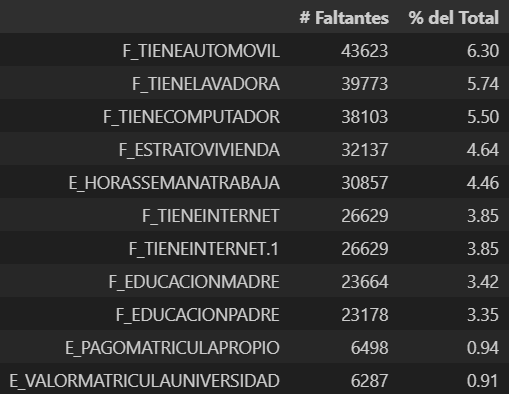

Otro factor crucial a considerar es que el análisis de datos faltantes no debe limitarse a la dimensión de la variable, sino que debe extenderse a la dimensión del individuo (fila/observación). Aquellos estudiantes (o registros) que presenten un porcentaje significativo de información faltante no deben ser imputados. En su lugar, es recomendable excluirlos del estudio (eliminación de filas) para evitar la introducción de sesgos en el modelo.

In [26]:
df_sin_id = df.drop(columns=['ID'], errors='ignore')
df_sin_id['n_faltantes'] = df_sin_id.isnull().sum(axis=1)
total_vars = df_sin_id.shape[1] - 1  # menos la columna n_faltantes
df_sin_id['pct_faltantes'] = (df_sin_id['n_faltantes'] / total_vars) * 100
faltantes_grupo = (
    df_sin_id['n_faltantes']
    .value_counts()
    .reset_index()
)
faltantes_grupo.columns = ['n_faltantes', 'n_estudiantes']
faltantes_grupo['pct_sobre_total_vars'] = (faltantes_grupo['n_faltantes'] / total_vars) * 100
faltantes_grupo = faltantes_grupo.sort_values(by='n_faltantes')
faltantes_grupo

,n_faltantes,n_estudiantes,pct_sobre_total_vars
0,0,628896,0.000000
2,1,16561,5.263158
3,2,10563,10.526316
4,3,8471,15.789474
5,4,2457,21.052632
8,5,1362,26.315789
6,6,2434,31.578947
9,7,937,36.842105
1,8,19162,42.105263
10,9,18,47.368421


### Eliminación de observaciones con alta proporción de faltantes

- **Criterio:** Estudiantes con más del 40% de variables faltantes (≥8 variables).
- **Magnitud del impacto:** Afecta aproximadamente 20,800 observaciones (≈3% del total).
- **Justificación:** Estas observaciones presentan patrones de ausencia no aleatorios, probablemente asociados a falta de información socioeconómica o institucional.

Su eliminación evita distorsionar las distribuciones marginales de las variables imputadas y mejora la estabilidad de los modelos posteriores.

In [27]:
print(f"Dimensión del dataframe antes : {df.shape}")
df['n_faltantes'] = df.isnull().sum(axis=1)
df['pct_faltantes'] = df.isnull().mean(axis=1) * 100
df = df[df['n_faltantes'] <  8]
print(f"Dimensión del dataframe despues : {df.shape}")

Dimensión del dataframe antes : (692500, 20)
Dimensión del dataframe despues : (671681, 22)


In [28]:
# Tabla de nulos para variables despues de la eliminación de datos
nulos = df.isnull().sum().sort_values(ascending=False)
pct_nulos = (df.isnull().mean().sort_values(ascending=False) * 100).round(2)
pd.concat([nulos, pct_nulos], axis=1, keys=['# Faltantes','% del Total']).head(10)

,# Faltantes,% del Total
F_TIENEAUTOMOVIL,22804,3.40
F_TIENELAVADORA,18954,2.82
F_TIENECOMPUTADOR,17284,2.57
F_ESTRATOVIVIENDA,11318,1.69
E_HORASSEMANATRABAJA,10041,1.49
F_TIENEINTERNET,5810,0.86
E_PAGOMATRICULAPROPIO,4806,0.72
E_VALORMATRICULAUNIVERSIDAD,4603,0.69
F_EDUCACIONMADRE,2880,0.43
F_EDUCACIONPADRE,2401,0.36


### Estrategia de imputación para variables categóricas

#### Imputación por moda global

Aplicada solo a 'F_ESTRATOVIVIENDA', 'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE' debido a su bajo porcentaje de valores faltantes y la ausencia de variables predictoras fuertes que permitan una imputación más específica. Esta estrategia mantiene la coherencia de la distribución original y evita introducir sesgos en el conjunto de datos.

In [29]:
# Moda global para variables categóricas simples
variables_imputar = ['F_ESTRATOVIVIENDA', 'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']
for col in variables_imputar:
    print(f"\n📊 Variable: {col}")
    nulos_antes = df[col].isna().sum()
    print(f" - Valores nulos antes de imputar: {nulos_antes}")
    moda_valor = df[col].mode()[0]
    print(f" - Valor usado para imputar (moda): {moda_valor}")
    df.loc[:, col] = df[col].fillna(moda_valor)
    nulos_despues = df[col].isna().sum()
    print(f" - Valores nulos después de imputar: {nulos_despues}")
print("\n✅ Imputación completada correctamente.")



📊 Variable: F_ESTRATOVIVIENDA
 - Valores nulos antes de imputar: 11318
 - Valor usado para imputar (moda): Estrato 2
 - Valores nulos después de imputar: 0

📊 Variable: F_EDUCACIONMADRE
 - Valores nulos antes de imputar: 2880
 - Valor usado para imputar (moda): Secundaria (Bachillerato) completa
 - Valores nulos después de imputar: 0

📊 Variable: F_EDUCACIONPADRE
 - Valores nulos antes de imputar: 2401
 - Valor usado para imputar (moda): Secundaria (Bachillerato) completa
 - Valores nulos después de imputar: 0

✅ Imputación completada correctamente.


### Imputación por moda condicional (segmentación socioeconómica)
Dado que todas las variables con datos faltantes son categóricas, se aplicó una imputación por la moda condicional dentro de grupos socioeconómicos (por ejemplo, el estrato de vivienda o el acceso a internet). Este enfoque preserva la coherencia estructural del conjunto de datos, ya que las características del hogar y las condiciones socioeconómicas tienden a estar correlacionadas entre sí. En consecuencia, se evita una imputación global que podría introducir sesgos y se mejora la representatividad contextual de los valores imputados.

In [30]:
# Imputación por grupos para variables categóricas
imputaciones_grupales = {
    'F_TIENEAUTOMOVIL': 'F_ESTRATOVIVIENDA',
    'F_TIENELAVADORA': 'F_ESTRATOVIVIENDA',
    'F_TIENEINTERNET': 'F_ESTRATOVIVIENDA',
    'F_TIENECOMPUTADOR': 'F_TIENEINTERNET',
    'E_PAGOMATRICULAPROPIO': 'F_ESTRATOVIVIENDA',
    'E_HORASSEMANATRABAJA': 'F_ESTRATOVIVIENDA',
    'E_VALORMATRICULAUNIVERSIDAD': 'F_ESTRATOVIVIENDA'
}

for var, grupo in imputaciones_grupales.items():
    print(f"\n📊 Variable: {var} (agrupada por {grupo})")
    nulos_antes = df[var].isna().sum()
    print(f" - Valores nulos antes de imputar: {nulos_antes}")
    
    # Imputación por moda dentro del grupo
    df[var] = df.groupby(grupo)[var].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No')
    )
    
    nulos_despues = df[var].isna().sum()
    print(f" - Valores nulos después de imputar: {nulos_despues}")

print("\n✅ Imputación por grupos completada correctamente.")



📊 Variable: F_TIENEAUTOMOVIL (agrupada por F_ESTRATOVIVIENDA)
 - Valores nulos antes de imputar: 22804
 - Valores nulos después de imputar: 0

📊 Variable: F_TIENELAVADORA (agrupada por F_ESTRATOVIVIENDA)
 - Valores nulos antes de imputar: 18954
 - Valores nulos después de imputar: 0

📊 Variable: F_TIENEINTERNET (agrupada por F_ESTRATOVIVIENDA)
 - Valores nulos antes de imputar: 5810
 - Valores nulos después de imputar: 0

📊 Variable: F_TIENECOMPUTADOR (agrupada por F_TIENEINTERNET)
 - Valores nulos antes de imputar: 17284
 - Valores nulos después de imputar: 0

📊 Variable: E_PAGOMATRICULAPROPIO (agrupada por F_ESTRATOVIVIENDA)
 - Valores nulos antes de imputar: 4806
 - Valores nulos después de imputar: 0

📊 Variable: E_HORASSEMANATRABAJA (agrupada por F_ESTRATOVIVIENDA)
 - Valores nulos antes de imputar: 10041
 - Valores nulos después de imputar: 0

📊 Variable: E_VALORMATRICULAUNIVERSIDAD (agrupada por F_ESTRATOVIVIENDA)
 - Valores nulos antes de imputar: 4603
 - Valores nulos después

## Normalización y Estandarización de variables númericas
Evita que variables con escalas relativamente grandes dominen el modelo y mejora la convergencia de algoritmos basados en distancia o gradiente.

In [31]:
num_vars = [
    'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4'
]
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])
df[num_vars]

,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,0.394724,-0.696747,0.964437,-0.060430
1,0.299967,-0.614471,0.536465,-0.115724
2,0.179368,-0.626225,0.845556,-0.115724
3,1.798846,-1.119880,-0.414583,-1.479646
4,0.343039,-0.414658,0.370032,0.437217
...,...,...,...,...
692495,-0.337487,0.043736,0.037165,0.750551
692496,0.325810,-0.320629,0.203599,-0.189449
692497,0.084611,-0.320629,1.059542,0.308198
692498,-1.241982,1.865558,-0.200597,1.063884


## Codificación variables Categoricas

#### **One-Hot Encoding:** para variables nominales sin orden inherente

In [32]:
one_hot_vars = [
    'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
    'F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL',
    'F_TIENECOMPUTADOR', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO'
]
df = pd.get_dummies(df, columns=one_hot_vars, drop_first=True)

#### **Ordinal Encoding:** para variables con jerarquía

In [33]:
# Orden lógico de los niveles educativos
orden_educacion = [
    'Ninguno',
    'Primaria incompleta',
    'Primaria completa',
    'Secundaria (Bachillerato) incompleta',
    'Secundaria (Bachillerato) completa',
    'Técnica o tecnológica incompleta',
    'Técnica o tecnológica completa',
    'Educación profesional incompleta',
    'Educación profesional completa',
    'Postgrado',
    'No sabe',
    'No Aplica'
]

# Crear diccionario de mapeo
mapeo_educacion = {nivel: i for i, nivel in enumerate(orden_educacion)}
mapeo_educacion['No sabe'] = 99
mapeo_educacion['No Aplica'] = 999

# Aplicar mapeo
df['F_EDUCACIONMADRE_ENCODED'] = df['F_EDUCACIONMADRE'].map(mapeo_educacion)
df['F_EDUCACIONPADRE_ENCODED'] = df['F_EDUCACIONPADRE'].map(mapeo_educacion)

In [34]:
# Mapeos de orden
estrato_map = {'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3, 'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6}
rend_map = {'bajo': 1, 'medio-bajo': 2, 'medio-alto': 3, 'alto':4}

# Aplicar reemplazos
df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].replace(estrato_map)
df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].replace(rend_map)


In [35]:
print("🔎 Resumen de valores nulos restantes por variable:\n")
print(df.isnull().sum().sort_values(ascending=False))

🔎 Resumen de valores nulos restantes por variable:

ID                                                                                                          0
E_PRGM_ACADEMICO_LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES: LENGUA CASTELLANA E INGLES    0
E_PRGM_ACADEMICO_LICENCIATURA EN EDUCACION ENFASIS EN INFORMATICA                                           0
E_PRGM_ACADEMICO_LICENCIATURA EN EDUCACION ESPECIAL                                                         0
E_PRGM_ACADEMICO_LICENCIATURA EN EDUCACION FISICA                                                           0
                                                                                                           ..
E_PRGM_ACADEMICO_FINANZAS Y COMERCIO INTERNACIONAL                                                          0
E_PRGM_ACADEMICO_FINANZAS Y NEGOCIOS INTERNACIONALES                                                        0
E_PRGM_ACADEMICO_FINANZAS Y RELACIONES INTERNACIONALES              

## Renombramento de columnas

In [ ]:
import re
import unicodedata

def abreviar_columna(nombre):
    nombre = ''.join(
        c for c in unicodedata.normalize('NFD', nombre)
        if unicodedata.category(c) != 'Mn'
    )
    if len(nombre) <= 40:
        return nombre
    partes = nombre.split('_')
    prefijo = '_'.join(partes[:-1])
    ultima = partes[-1]
    ultima = re.sub(r'[^A-Z0-9 ]+', ' ', ultima)
    abreviado = '_'.join([p[:3] for p in ultima.split() if len(p) > 3])

    return f"{prefijo}_{abreviado}"

df.columns = [abreviar_columna(col) for col in df.columns]
df = df.drop(columns=['n_faltantes', 'pct_faltantes'])
print(df.columns.tolist())


['ID', 'PERIODO_ACADEMICO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4', 'n_faltantes', 'pct_faltantes', 'E_PRGM_ACADEMICO_ACT_FIS_DEP', 'E_PRGM_ACADEMICO_ACUICULTURA', 'E_PRGM_ACADEMICO_ADMINISTRACION', 'E_PRGM_ACADEMICO_ADM_FIN', 'E_PRGM_ACADEMICO_ADM_SER', 'E_PRGM_ACADEMICO_ADM_AER', 'E_PRGM_ACADEMICO_ADM_AGR', 'E_PRGM_ACADEMICO_ADM_AGR', 'E_PRGM_ACADEMICO_ADM_AMB', 'E_PRGM_ACADEMICO_ADM_AMB_REC_NAT', 'E_PRGM_ACADEMICO_ADM_BAN_FIN', 'E_PRGM_ACADEMICO_ADM_COM', 'E_PRGM_ACADEMICO_ADM_COM_MER', 'E_PRGM_ACADEMICO_ADM_COM_FIN', 'E_PRGM_ACADEMICO_ADM_AGR', 'E_PRGM_ACADEMICO_ADM_COM_EXT', 'E_PRGM_ACADEMICO_ADM_EMP', 'E_PRGM_ACADEMICO_ADM_EMP_GES_AMB', 'E_PRGM_ACADEMICO_ADM_EMP_CIC_PRO', 'E_PRGM_ACADEMICO_ADM_EMP_AGR', 'E_PRGM_ACADEMICO_ADM_EMP_AGR', 'E_PRGM_ACADEMICO_ADM_EMP_COM', 'E_PRGM_ACADEMICO_ADM_EMP_TEL', 'E_PRGM_ACADEMICO_ADM_EMP_T

# Dimensión Final 

In [39]:
print("✅ PREPROCESAMIENTO FINALIZADO")
print(f"📊 Dimensión final del DataFrame: {df.shape}")
print(f"📈 Total de variables: {df.shape[1]}")
print(f"📋 Total de observaciones: {df.shape[0]}")

✅ PREPROCESAMIENTO FINALIZADO
📊 Dimensión final del DataFrame: (671681, 834)
📈 Total de variables: 834
📋 Total de observaciones: 671681
